## Retail Store Inventory and Demand Forecasting

In [1]:
!pip install -q pandas numpy scikit-learn statsmodels matplotlib pyarrow ipywidgets

## Import dan Konfigurasi

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (12,5)
sns.set(style="whitegrid")

## 1. loading dan validasi dataset
Di bagian ini, kita membaca dataset dan melakukan validasi awal:
- Pastikan file CSV ada dan bisa dibaca dengan berbagai delimiter.
- Pastikan kolom `Date` terdeteksi sebagai tipe datetime.
- Pastikan kolom target `Demand` tersedia.
- Tampilkan shape dataset, rentang tanggal, dan jumlah tanggal unik.


In [6]:
def load_and_validate(path, date_col='Date', target_col='Demand', expect_cols=None):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    # robust read
    try:
        df = pd.read_csv(path, sep=None, engine='python', parse_dates=[date_col])
    except Exception:
        seps = [',',';','\t','|']
        df = None
        for sep in seps:
            try:
                df = pd.read_csv(path, sep=sep, engine='python', parse_dates=[date_col])
                if df.shape[1] > 1:
                    break
            except Exception:
                df = None
        if df is None:
            raise RuntimeError("Failed to read CSV with tried separators.")

    # ensure date col exists and parsed
    if date_col not in df.columns:
        raise KeyError(f"Date column '{date_col}' not found. Columns: {df.columns.tolist()}")
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    if df[date_col].isna().all():
        raise ValueError(f"All values in '{date_col}' are NaT after parsing. Show sample: {df[date_col].head(10).tolist()}")

    # fallback target
    if target_col not in df.columns and 'Units Sold' in df.columns:
        df[target_col] = df['Units Sold']
        print(f"[INFO] Using 'Units Sold' as '{target_col}' fallback.")
    if target_col not in df.columns:
        raise KeyError(f"Target column '{target_col}' not found. Columns: {df.columns.tolist()}")

    # quick report
    print("Loaded shape:", df.shape)
    print("Date range:", df[date_col].min(), "->", df[date_col].max(), "| unique dates:", df[date_col].nunique())
    if expect_cols:
        miss = [c for c in expect_cols if c not in df.columns]
        if miss: print("[WARN] Missing expected cols:", miss)
    return df

DATA_PATH = r"C:\Users\MSI Modern 14\codee\portooo\Retail Store Inventory and Demand Forecasting\retail_demand_portfolio\sales_data.csv"

# 1) load
df = load_and_validate(DATA_PATH, date_col='Date', target_col='Demand',
                       expect_cols=['Promotion','Epidemic','Category','Store ID'])

Loaded shape: (76000, 16)
Date range: 2022-01-01 00:00:00 -> 2024-01-30 00:00:00 | unique dates: 760


## 2. Exploratory Data Analysis (EDA)
Di bagian ini, kita melakukan eksplorasi data untuk memahami pola demand, tren musiman, dan pengaruh variabel eksternal seperti promo dan epidemi.


### 2.1 Trend dan Musiman
- Kita melihat **demand harian** dari waktu ke waktu.
- Menggunakan **rolling mean 30 hari** untuk menangkap tren jangka panjang.
- Mengelompokkan demand per bulan untuk melihat pola musiman bulanan.
- Menghitung rata-rata demand per hari dalam minggu untuk melihat efek weekday.
- Membuat **heatmap month x weekday** untuk visualisasi interaksi musiman.


Daily shape (resampled): (760, 2)
        Date  Demand
0 2022-01-01   10060
1 2022-01-02   10814
2 2022-01-03   11317
3 2022-01-04   11469
4 2022-01-05   11724 
...           Date  Demand
755 2024-01-26   11182
756 2024-01-27   11540
757 2024-01-28   11440
758 2024-01-29   10268
759 2024-01-30    9657


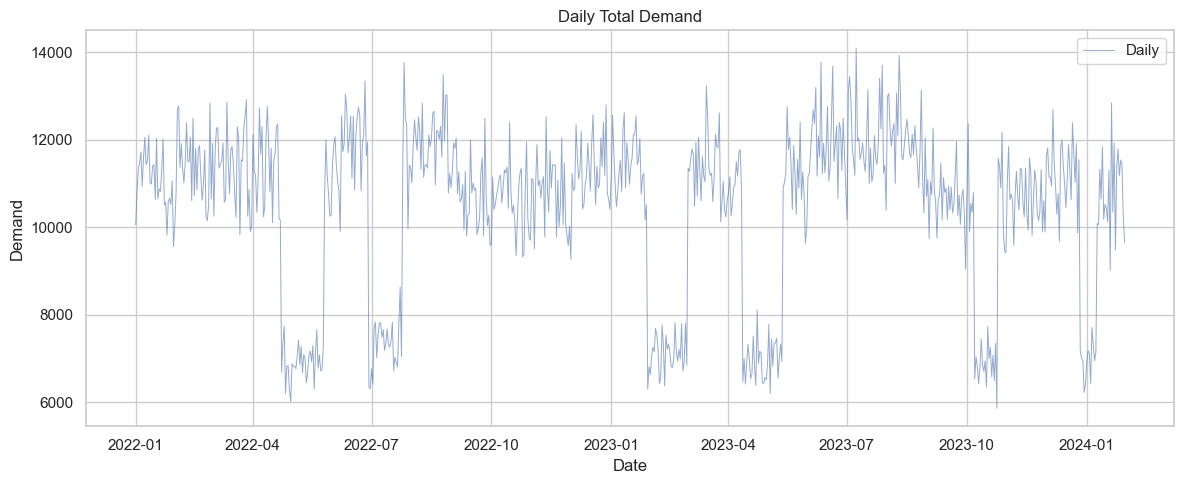

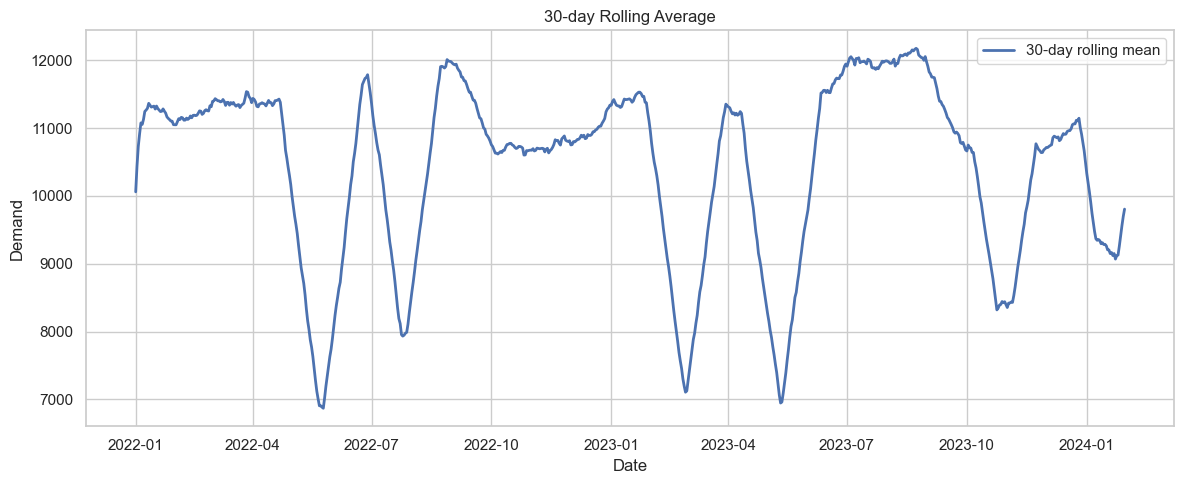

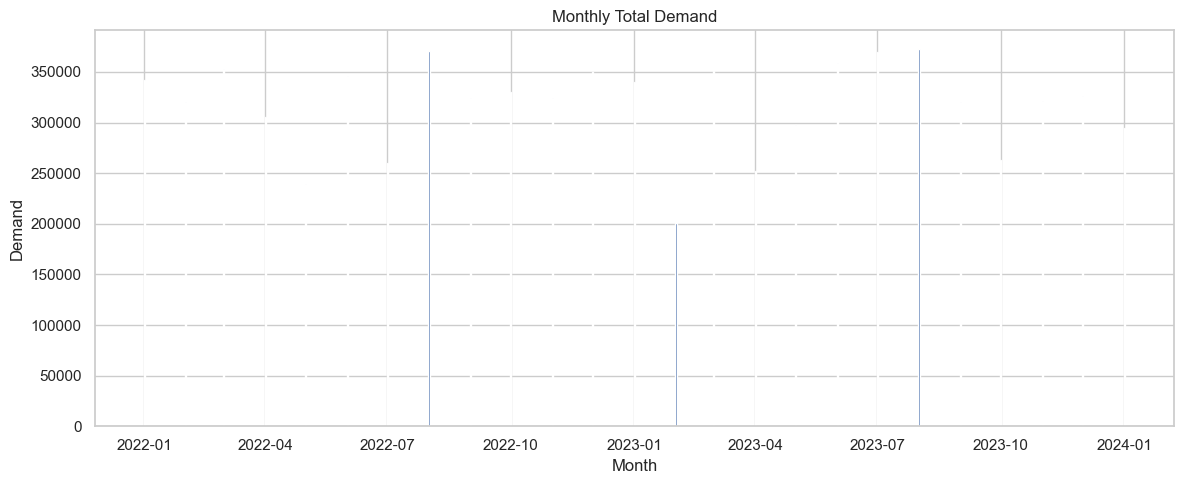

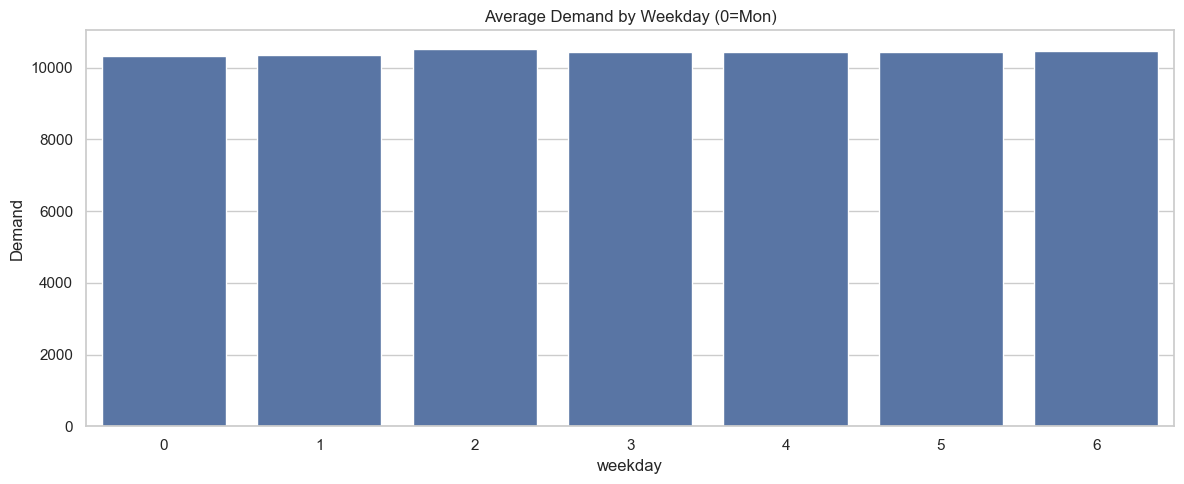

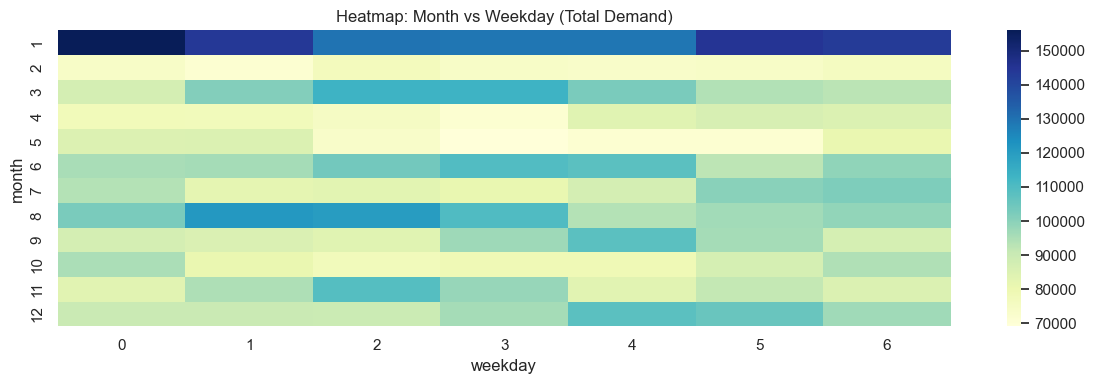

In [11]:
def eda_trend_seasonality(df, date_col='Date', target_col='Demand', rolling_window=30, save_plots=False, out_prefix='eda'):
    df = df.copy()
    if date_col not in df.columns:
        raise KeyError(f"Date column '{date_col}' not found. Columns: {df.columns.tolist()}")
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col, target_col]).reset_index(drop=True)

    # DAILY via resample (robust)
    df_idx = df.set_index(date_col)
    daily = df_idx[target_col].resample('D').sum().reset_index()

    print("Daily shape (resampled):", daily.shape)
    print(daily.head(), "\n...", daily.tail())

    # raw daily plot
    plt.figure()
    plt.plot(daily[date_col], daily[target_col], linewidth=0.7, alpha=0.6, label='Daily')
    plt.title('Daily Total Demand'); plt.xlabel('Date'); plt.ylabel(target_col); plt.legend(); plt.tight_layout()
    if save_plots: plt.savefig(f"{out_prefix}_daily.png", dpi=150)
    plt.show()

    # rolling
    daily['rolling'] = daily[target_col].rolling(window=rolling_window, min_periods=1).mean()
    plt.figure()
    plt.plot(daily[date_col], daily['rolling'], linewidth=2, label=f'{rolling_window}-day rolling mean')
    plt.title(f'{rolling_window}-day Rolling Average'); plt.xlabel('Date'); plt.ylabel(target_col); plt.legend(); plt.tight_layout()
    if save_plots: plt.savefig(f"{out_prefix}_rolling.png", dpi=150)
    plt.show()

    # monthly aggregate
    monthly = daily.copy()
    monthly['month'] = monthly[date_col].dt.to_period('M')
    monthly_agg = monthly.groupby('month')[target_col].sum().reset_index()
    monthly_agg['month_start'] = monthly_agg['month'].dt.to_timestamp()
    plt.figure()
    plt.bar(monthly_agg['month_start'], monthly_agg[target_col])
    plt.title('Monthly Total Demand'); plt.xlabel('Month'); plt.ylabel(target_col); plt.tight_layout()
    if save_plots: plt.savefig(f"{out_prefix}_monthly.png", dpi=150)
    plt.show()

    # weekday averages
    daily['weekday'] = daily[date_col].dt.weekday
    weekly = daily.groupby('weekday')[target_col].mean().reset_index()
    plt.figure()
    sns.barplot(x='weekday', y=target_col, data=weekly)
    plt.title('Average Demand by Weekday (0=Mon)'); plt.tight_layout()
    if save_plots: plt.savefig(f"{out_prefix}_weekday.png", dpi=150)
    plt.show()

    # heatmap month x weekday using original df
    df['month'] = df[date_col].dt.month
    df['weekday'] = df[date_col].dt.weekday
    pivot = df.groupby(['month','weekday'])[target_col].sum().unstack(fill_value=0)
    plt.figure(figsize=(12,4))
    sns.heatmap(pivot, cmap='YlGnBu', annot=False)
    plt.title('Heatmap: Month vs Weekday (Total Demand)'); plt.tight_layout()
    if save_plots: plt.savefig(f"{out_prefix}_heatmap.png", dpi=150)
    plt.show()

    return daily, monthly_agg, weekly, pivot

daily, monthly, weekly, pivot = eda_trend_seasonality(df, date_col='Date', target_col='Demand', rolling_window=30)


### 2.2 Pengaruh Promo dan Epidemic
- Analisis pengaruh **promo** terhadap demand: rata-rata, median, dan distribusi demand.
- Analisis pengaruh **epidemic** terhadap demand: rata-rata, median, dan distribusi demand.
- Analisis **interaksi promo x epidemic**, termasuk rolling demand per promo flag.


Promo summary:
    Promotion        mean  median  count
0          0   95.026843    92.0  51000
1          1  123.269400   120.0  25000


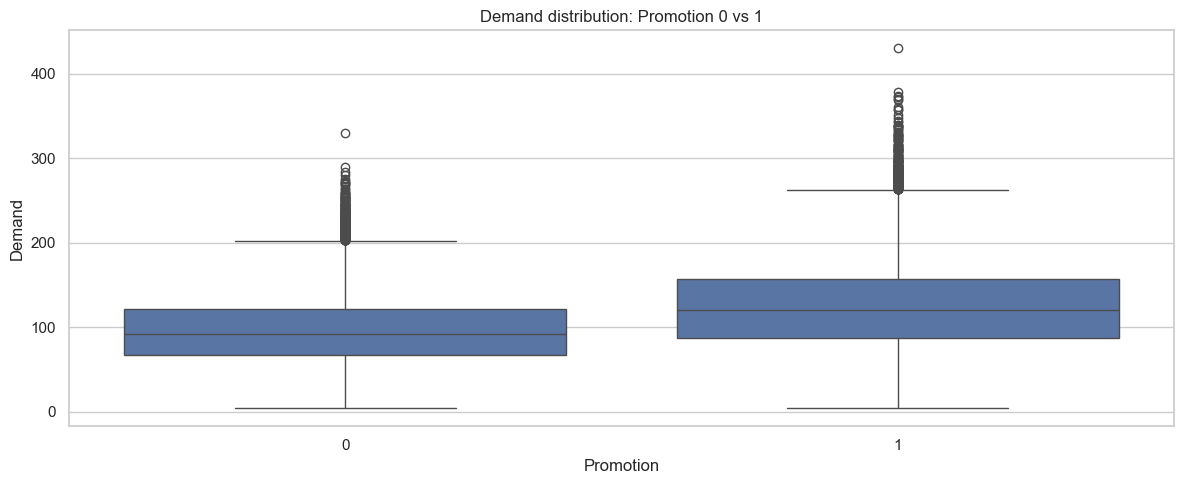

Epidemic summary:
    Epidemic        mean  median  count
0         0  112.856743   108.0  60800
1         1   70.158816    64.0  15200


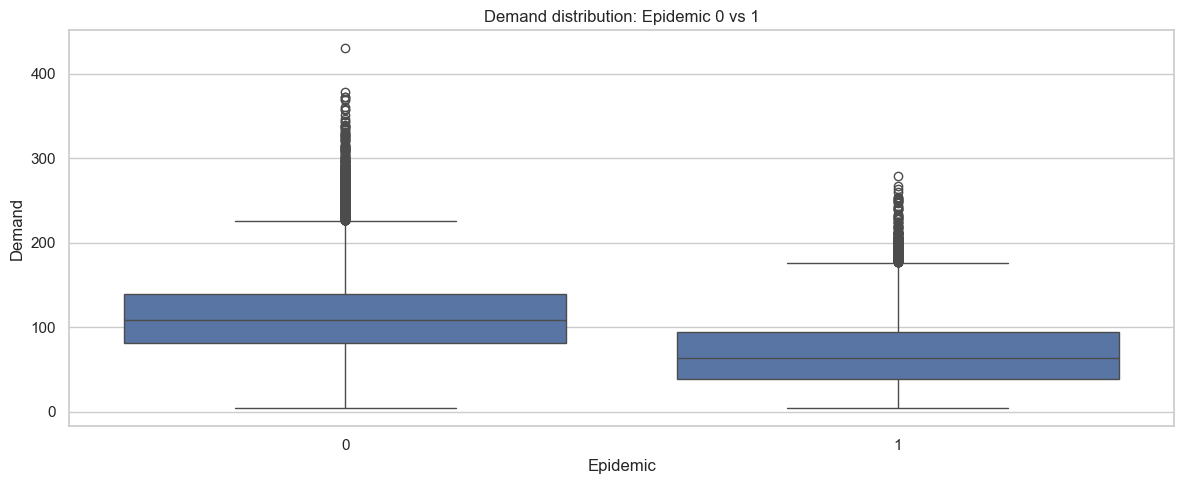

Promotion x Epidemic interaction:
    Promotion  Epidemic        mean  median  count
0          0         0  102.766503    99.0  40810
1          0         1   64.030226    58.0  10190
2          1         0  133.456178   129.0  19990
3          1         1   82.623952    76.0   5010


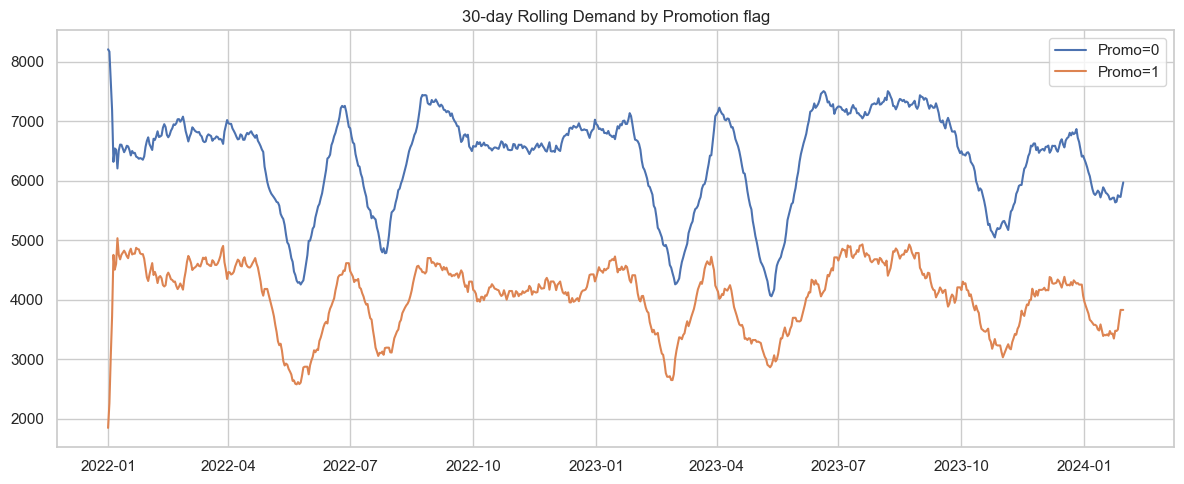

In [12]:
def eda_promo_epidemic(df, date_col='Date', target_col='Demand', promo_col='Promotion', epi_col='Epidemic', save_plots=False, out_prefix='eda'):
    df = df.copy()
    if date_col not in df.columns:
        raise KeyError(f"Date column '{date_col}' not found. Columns: {df.columns.tolist()}")
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col, target_col]).reset_index(drop=True)

    # normalize flags if present
    if promo_col in df.columns:
        df[promo_col] = pd.to_numeric(df[promo_col], errors='coerce').fillna(0).astype(int)
    if epi_col in df.columns:
        df[epi_col] = pd.to_numeric(df[epi_col], errors='coerce').fillna(0).astype(int)

    promo_summary = None
    if promo_col in df.columns:
        promo_summary = df.groupby(promo_col)[target_col].agg(['mean','median','count']).reset_index()
        print("Promo summary:\n", promo_summary)
        plt.figure()
        sns.boxplot(x=promo_col, y=target_col, data=df)
        plt.title('Demand distribution: Promotion 0 vs 1'); plt.tight_layout(); plt.show()
    else:
        print("[INFO] Promotion column not present.")

    epi_summary = None
    if epi_col in df.columns:
        epi_summary = df.groupby(epi_col)[target_col].agg(['mean','median','count']).reset_index()
        print("Epidemic summary:\n", epi_summary)
        plt.figure()
        sns.boxplot(x=epi_col, y=target_col, data=df)
        plt.title('Demand distribution: Epidemic 0 vs 1'); plt.tight_layout(); plt.show()
    else:
        print("[INFO] Epidemic column not present.")

    inter = None
    if (promo_col in df.columns) and (epi_col in df.columns):
        inter = df.groupby([promo_col, epi_col])[target_col].agg(['mean','median','count']).reset_index()
        print("Promotion x Epidemic interaction:\n", inter)
        # time series per promo flag using resample + pivot
        df_idx = df.set_index(date_col)
        daily_promo = df_idx.groupby([pd.Grouper(freq='D'), promo_col])[target_col].sum().unstack(fill_value=0)
        plt.figure()
        for col in daily_promo.columns:
            plt.plot(daily_promo.index, daily_promo[col].rolling(30, min_periods=1).mean(), label=f'Promo={col}')
        plt.title('30-day Rolling Demand by Promotion flag'); plt.legend(); plt.tight_layout(); plt.show()
    else:
        print("[INFO] Cannot compute interaction (missing promo or epidemic column).")

    return promo_summary, epi_summary, inter

promo_summary, epi_summary, interaction = eda_promo_epidemic(df, date_col='Date', target_col='Demand', promo_col='Promotion', epi_col='Epidemic')

### 2.3 Insight Awal
- Promo menaikkan demand: rata-rata demand saat promo aktif (Promotion=1) adalah 123 unit, dibandingkan 95 unit tanpa promo (Promotion=0). Ini menunjukkan promo efektif meningkatkan penjualan.
- Epidemic menurunkan demand: rata-rata demand saat epidemic (Epidemic=1) hanya 70 unit, dibandingkan 113 unit saat tidak ada epidemic (Epidemic=0).
- Interaksi promo x epidemic:
1. Tanpa promo & epidemic: mean = 103 unit
2. Promo & tidak epidemic: mean = 133 unit (peningkatan signifikan)
3. Promo & epidemic: mean = 83 unit → lebih tinggi dibanding tanpa promo & epidemic (64 unit), menunjukkan promo membantu menstabilkan demand meski ada gangguan.
   
- Pola musiman mingguan jelas: weekday vs weekend menunjukkan variasi demand yang konsisten.
- Tren jangka panjang: rolling mean 30 hari menunjukkan fluktuasi gradual, berguna untuk perencanaan stok jangka panjang dan prediksi demand.

## 3. Feature Engineering
Di bagian ini, kita membuat fitur tambahan dari data asli untuk meningkatkan performa forecasting demand.

**Fitur yang dibuat:**
1. **Time-based features**:
   - `dayofweek`: hari dalam minggu (0=Senin, 6=Minggu)
   - `month`: bulan (1-12)
   - `quarter`: kuartal (1-4)
   - `is_weekend`: flag akhir pekan (0=weekday, 1=weekend)
2. **Lag features**:
   - `lag_1`, `lag_7`, `lag_14`: nilai demand sebelumnya (1, 7, 14 hari sebelumnya)
3. **Rolling mean features**:
   - `roll_mean_7`, `roll_mean_30`: rata-rata demand 7-hari dan 30-hari sebelumnya


In [14]:
import pandas as pd

def feature_engineering(df, date_col="Date", target_col="Demand", lags=[1,7,14], roll_windows=[7,30]):
    """
    Create time-based, lag, and rolling features for demand forecasting.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.sort_values(date_col).reset_index(drop=True)

    # Time-based features
    df["dayofweek"] = df[date_col].dt.dayofweek  # 0=Mon, 6=Sun
    df["month"] = df[date_col].dt.month
    df["quarter"] = df[date_col].dt.quarter
    df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)

    # Lag features
    for lag in lags:
        df[f"lag_{lag}"] = df[target_col].shift(lag)

    # Rolling mean features
    for w in roll_windows:
        df[f"roll_mean_{w}"] = df[target_col].shift(1).rolling(window=w).mean()

    # Drop NA (caused by lags/rolling)
    df = df.dropna().reset_index(drop=True)
    
    return df

# 🚀 Jalankan
df_fe = feature_engineering(df, date_col="Date", target_col="Demand")

print("Feature engineered shape:", df_fe.shape)
df_fe.head(10)


Feature engineered shape: (75970, 25)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,...,Demand,dayofweek,month,quarter,is_weekend,lag_1,lag_7,lag_14,roll_mean_7,roll_mean_30
0,2022-01-01,S005,P0016,Toys,North,131,59,191,32.84,0,...,76,5,1,1,1,88.0,71.0,75.0,78.571429,94.366667
1,2022-01-01,S005,P0015,Groceries,North,132,108,203,44.36,10,...,93,5,1,1,1,76.0,85.0,82.0,79.285714,93.066667
2,2022-01-01,S005,P0014,Furniture,North,193,63,219,161.18,10,...,82,5,1,1,1,93.0,67.0,108.0,80.428571,92.500000
3,2022-01-01,S005,P0013,Groceries,North,145,82,328,71.03,10,...,116,5,1,1,1,82.0,104.0,133.0,82.571429,91.800000
4,2022-01-01,S005,P0012,Furniture,North,230,71,371,133.86,5,...,84,5,1,1,1,116.0,47.0,44.0,84.285714,93.633333
5,2022-01-01,S005,P0011,Electronics,North,220,17,0,62.12,0,...,15,5,1,1,1,84.0,88.0,176.0,89.571429,92.166667
6,2022-01-01,S003,P0012,Furniture,East,126,58,131,105.94,0,...,80,5,1,1,1,15.0,88.0,70.0,79.142857,89.400000
7,2022-01-01,S005,P0010,Groceries,North,132,132,436,70.86,0,...,136,5,1,1,1,80.0,76.0,71.0,78.000000,89.400000
8,2022-01-01,S005,P0008,Groceries,North,229,165,0,73.42,0,...,149,5,1,1,1,136.0,93.0,85.0,86.571429,91.766667
9,2022-01-01,S005,P0007,Groceries,North,297,74,0,82.73,0,...,85,5,1,1,1,149.0,82.0,67.0,94.571429,94.300000


### Tujuan Feature Engineering
- Membantu model **menangkap pola musiman dan tren jangka pendek/panjang**.
- Lag dan rolling mean memungkinkan model melihat **nilai historis demand** untuk prediksi hari berikutnya.
- Time-based features menangkap **efek hari, bulan, kuartal, dan weekend** pada demand.

### Insight Awal
- Dengan heatmap korelasi, kita bisa melihat hubungan antar fitur numerik.
- Lag dan rolling mean biasanya memiliki korelasi tinggi dengan target (`Demand`), sehingga potensial meningkatkan akurasi model forecasting.


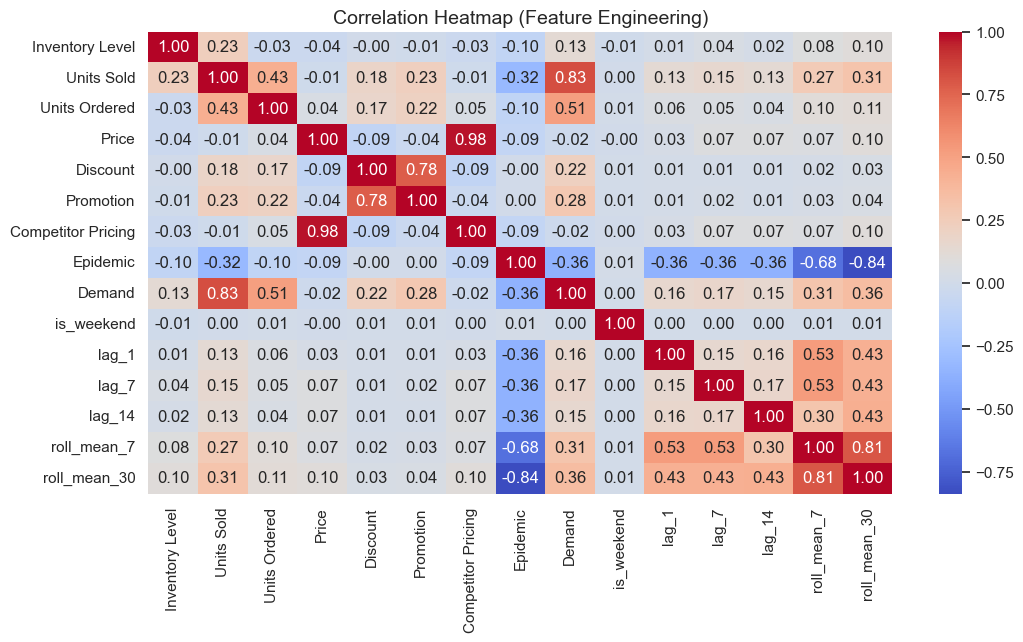

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil hanya kolom numerik (biar heatmap rapi)
num_cols = df_fe.select_dtypes(include=['int64','float64']).columns

plt.figure(figsize=(12,6))
sns.heatmap(df_fe[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap (Feature Engineering)", fontsize=14)
plt.show()


## 4. Train-Test Split (Time-Based)

Pada kasus forecasting, kita tidak bisa menggunakan random split karena dapat menyebabkan kebocoran data dari masa depan ke masa lalu.  
Oleh karena itu, pembagian dilakukan secara **berdasarkan urutan waktu**.

- Train set: 1 Jan 2022 → 1 Sep 2023 (60.776 data)  
- Test set : 1 Sep 2023 → 30 Jan 2024 (15.194 data)  

Metode ini lebih realistis karena model akan benar-benar diuji pada data "masa depan" yang tidak terlihat sebelumnya.


In [17]:
# Kita ambil data setelah feature engineering
df_ts = df_fe.copy()

# Tentukan cutoff date untuk split (misal 80% train, 20% test)
cutoff = int(len(df_ts) * 0.8)
train = df_ts.iloc[:cutoff]
test  = df_ts.iloc[cutoff:]

print("Train range:", train['Date'].min(), "->", train['Date'].max(), "| shape:", train.shape)
print("Test  range:", test['Date'].min(), "->", test['Date'].max(), "| shape:", test.shape)


Train range: 2022-01-01 00:00:00 -> 2023-09-01 00:00:00 | shape: (60776, 25)
Test  range: 2023-09-01 00:00:00 -> 2024-01-30 00:00:00 | shape: (15194, 25)


## 5. Baseline Forecasting pada Data Demand
Notebook ini membahas dua baseline model forecasting, yaitu Naive Forecast dan Moving Average, 
untuk membandingkan performa awal sebelum menggunakan model yang lebih kompleks.


Naive Forecast -> MAE: 44.85 | RMSE: 57.35
Moving Average (7d) -> MAE: 34.16 | RMSE: 43.40


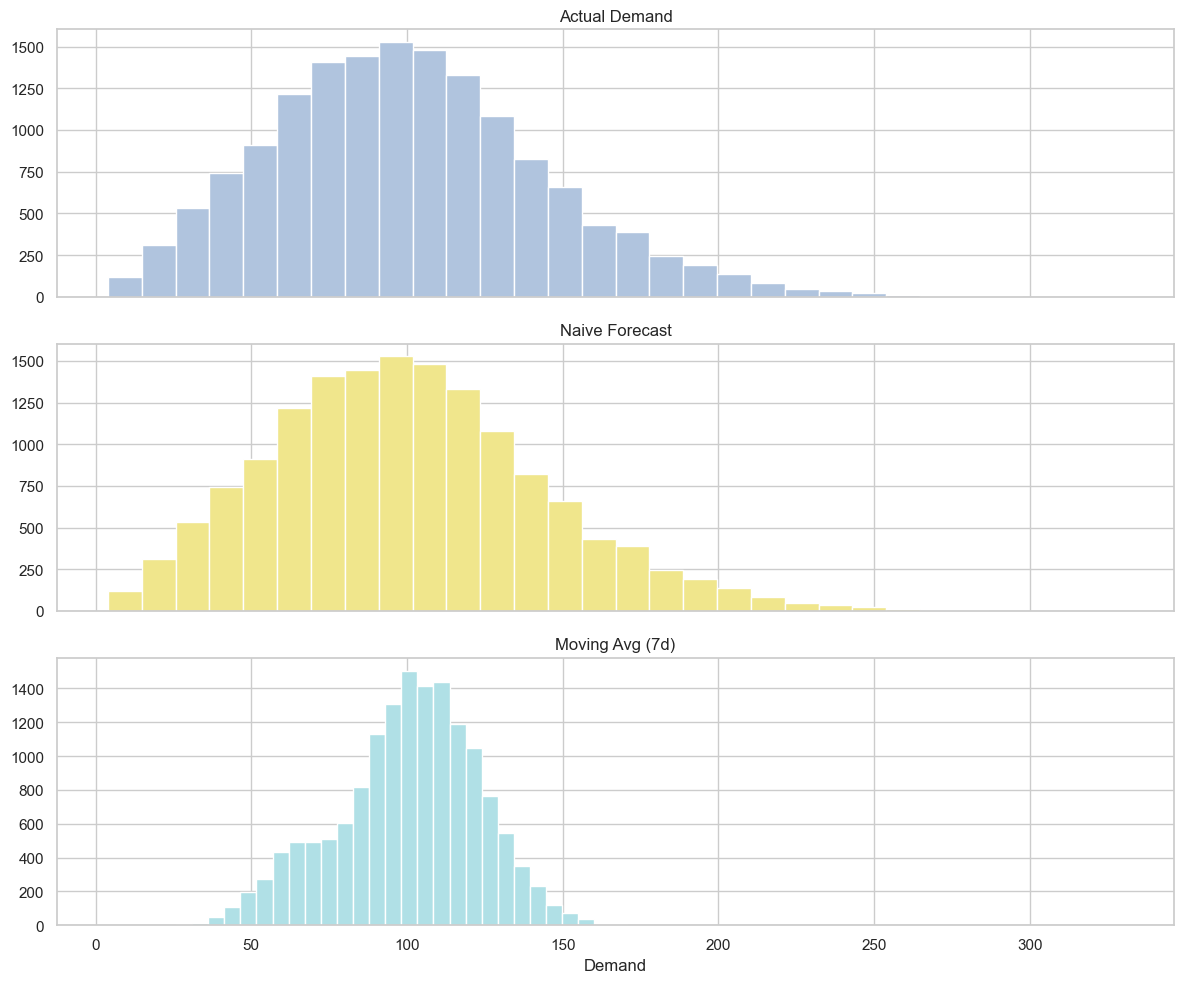

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Kita pakai hasil split sebelumnya
y_train = train["Demand"].values
y_test  = test["Demand"].values
dates_test = test["Date"].values

# --- 1) Naïve Forecast (besok = hari ini) ---
naive_forecast = np.roll(y_test, 1)
naive_forecast[0] = y_train[-1]  # nilai pertama di test ambil dari train terakhir

# --- 2) Moving Average (window=7) ---
window = 7
ma_forecast = []
history = list(y_train)

for t in range(len(y_test)):
    if len(history) >= window:
        pred = np.mean(history[-window:])
    else:
        pred = np.mean(history)  # fallback
    ma_forecast.append(pred)
    history.append(y_test[t])

ma_forecast = np.array(ma_forecast)

# --- Evaluasi ---
def evaluate(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> MAE: {mae:.2f} | RMSE: {rmse:.2f}")

evaluate(y_test, naive_forecast, "Naive Forecast")
evaluate(y_test, ma_forecast, "Moving Average (7d)")

fig, axes = plt.subplots(3, 1, figsize=(12,10), sharex=True)

axes[0].hist(y_test, bins=30, color="lightsteelblue")
axes[0].set_title("Actual Demand")

axes[1].hist(naive_forecast, bins=30, color="khaki")
axes[1].set_title("Naive Forecast")

axes[2].hist(ma_forecast, bins=30, color="powderblue")
axes[2].set_title("Moving Avg (7d)")

plt.xlabel("Demand")
plt.tight_layout()
plt.show()


### Kesimpulan
- Naïve Forecast menghasilkan MAE = 44.85 dan RMSE = 57.35.  
- Moving Average (7 hari) lebih baik dengan MAE = 34.16 dan RMSE = 43.40.  
- Artinya, penggunaan informasi rata-rata permintaan 7 hari terakhir lebih efektif dibanding hanya menyalin permintaan hari sebelumnya.


## 6. SARIMAX dengan exogenous features (Promotion & Epidemic)
Kita menggunakan model SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) 
untuk memprediksi demand. Variabel `Promotion` dan `Epidemic` digunakan sebagai faktor eksternal (exogenous features).


In [21]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Pastikan df sudah ada dengan kolom Date, Demand, Promotion, Epidemic
df["Date"] = pd.to_datetime(df["Date"])
df_daily = df.groupby("Date", as_index=False).agg({
    "Demand": "sum",
    "Promotion": "sum",
    "Epidemic": "sum"
})

# rename biar konsisten
df_daily.rename(columns={"Promotion": "Promo"}, inplace=True)

print(df_daily.head())


# --- 1) Ambil subset data untuk time series ---
ts = df_daily.set_index("Date")[["Demand","Promo","Epidemic"]]

# --- 2) Train-test split (time-based, misal 80-20) ---
split = int(len(ts)*0.8)
train, test = ts.iloc[:split], ts.iloc[split:]

# --- 3) SARIMAX dengan exogenous (Promo, Epidemic) ---
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

order = (1,1,1)
seasonal_order = (1,1,1,7)
model = sm.tsa.SARIMAX(
    train["Demand"],
    exog=train[["Promo","Epidemic"]],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

result = model.fit(disp=False)
print(result.summary())

# --- 4) Forecast ---
forecast = result.get_forecast(
    steps=len(test),
    exog=test[["Promo","Epidemic"]]
)
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

# --- 5) Evaluate ---
mae = mean_absolute_error(test["Demand"], pred_mean)
rmse = np.sqrt(mean_squared_error(test["Demand"], pred_mean))

print(f"SARIMAX -> MAE: {mae:.2f} | RMSE: {rmse:.2f}")

        Date  Demand  Promo  Epidemic
0 2022-01-01   10060     15         0
1 2022-01-02   10814     20         0
2 2022-01-03   11317     35         0
3 2022-01-04   11469     45         0
4 2022-01-05   11724     70         0


C:\Users\MSI Modern 14\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Modern 14\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Modern 14\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                            Demand   No. Observations:                  608
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4699.635
Date:                           Wed, 27 Aug 2025   AIC                           9413.269
Time:                                   14:19:57   BIC                           9443.942
Sample:                               01-01-2022   HQIC                          9425.217
                                    - 08-31-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Promo         22.8351      1.746     13.079      0.000      19.413      26.257
Epidemic     -38.7197      1.184    -32.711

Hasil evaluasi menunjukkan:
- MAE: 1181.76
- RMSE: 1305.37

Angka error cukup tinggi dibanding baseline (Moving Average MAE ~34), 
kemungkinan karena model mencoba mempelajari data harian dengan skala demand yang sangat besar (ribuan per hari).


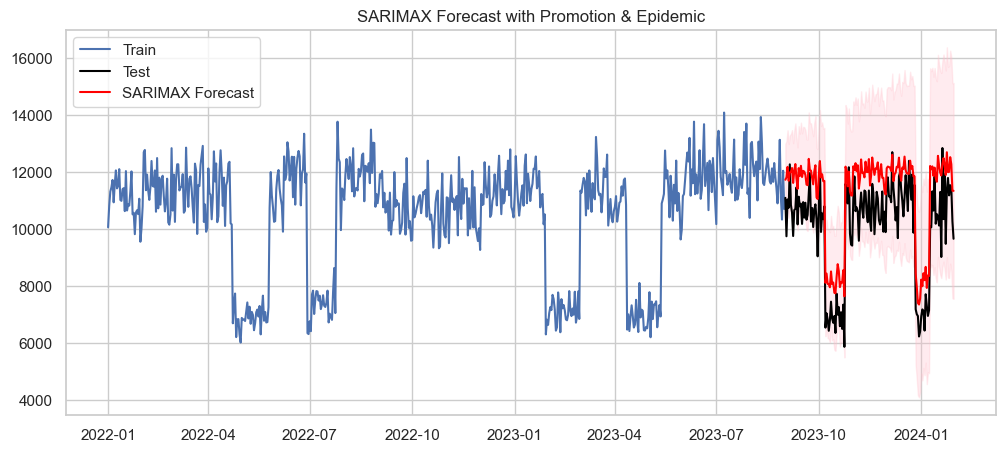

In [22]:
# --- 6) Plot hasil ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train.index, train["Demand"], label="Train")
plt.plot(test.index, test["Demand"], label="Test", color="black")
plt.plot(pred_mean.index, pred_mean, label="SARIMAX Forecast", color="red")

plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:,0],
                 pred_ci.iloc[:,1],
                 color="pink", alpha=0.3)
plt.legend()
plt.title("SARIMAX Forecast with Promotion & Epidemic")
plt.show()

Grafik berikut memperlihatkan perbandingan data train, test, dan hasil forecast SARIMAX.

- Promo terbukti meningkatkan penjualan (koefisien positif).
- Epidemi menurunkan permintaan secara signifikan (koefisien negatif).
- Meski error forecasting masih cukup tinggi, model SARIMAX sudah berhasil menangkap arah pengaruh faktor eksternal.
- Selanjutnya bisa dicoba model lain (XGBoost, LSTM, Prophet) untuk membandingkan performa.
